<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://goo.gl/rvvZiR).**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

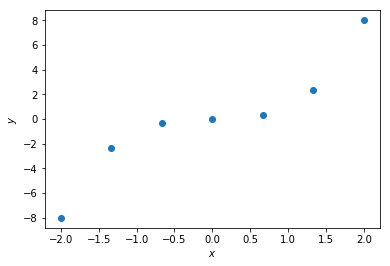

In [34]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график.

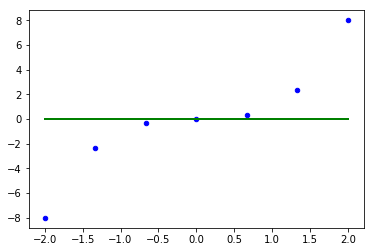

In [25]:
from sklearn.tree import DecisionTreeRegressor
tree1 = DecisionTreeRegressor(max_depth=1, random_state=1)
# print(X,y)
tree1.fit(X.reshape(-1,1),y)
X_test = np.linspace(-2, 2, 150)
# print(X_test)
# reg_tree_pred = tree1.predict(X_test.reshape(-1,1))
reg_tree_pred = np.full([150,], np.mean(y))
# reg_tree_pred = reg_tree_pred.fill(np.mean(y))
# print(reg_tree_pred, np.mean(y))
plt.scatter(X, y, c="b", s=20)
plt.plot(X_test, reg_tree_pred, "g", lw=2)

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

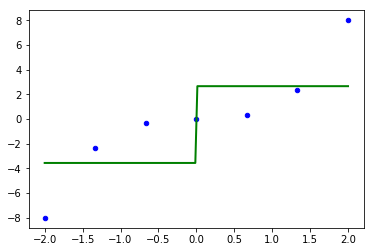

In [36]:
X_left = []
y_left = []
X_right = []
y_right = []
y_pred = []
# print(y)
for x,y_f in zip(X,y):
    if x < 0 : 
        X_left.append(x)
        y_left.append(y_f)
    else: 
        X_right.append(x)
        y_right.append(y_f)
for x in X_test:
    if x < 0 : 
        y_pred.append(np.mean(y_left))
    else: 
        y_pred.append(np.mean(y_right))
# print(y_left)
plt.scatter(X, y, c="b", s=20)
plt.plot(X_test, y_pred, "g", lw=2)

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [44]:
def disp(X, y):
    return 1/(len(X))*np.sum((y - 1/(len(X))*np.sum(y))**2)
def regression_var_criterion(X, y, t):
    X_left = []
    y_left = []
    X_right = []
    y_right = []
    for x,y_f in zip(X,y):
        if x < t : 
            X_left.append(x)
            y_left.append(y_f)
        else: 
            X_right.append(x)
            y_right.append(y_f)
    return (np.std(y)**2 - len(X_left)/(len(X))*(np.std(y_left)**2) - len(X_right)/(len(X))*(np.std(y_right)**2))
#     return disp(X,y) - len(X_left)/(len(X))*disp(X_left, y_left) - len(X_right)/(len(X))*disp(X_right, y_right)

[-2.         -1.33333333 -0.66666667  0.          0.66666667  1.33333333
  2.        ] [-8.         -2.37037037 -0.2962963   0.          0.2962963   2.37037037
  8.        ]


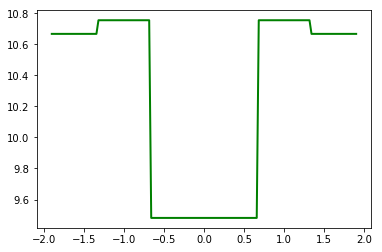

In [45]:
print(X, y)
t_space = np.linspace(-1.9, 1.9, 151)
Q_pred = []
for t in t_space:
    Q_pred.append(regression_var_criterion(X,y,t))
plt.plot(t_space, Q_pred, "g", lw=2)
# нет

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

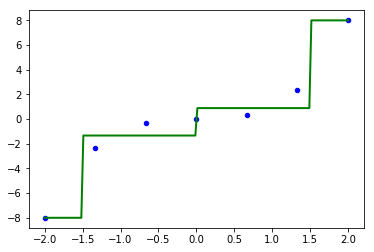

In [47]:
y_left_right = []
y_left_left = []
y_right_left = []
y_right_right = []
y_pred = []
# print(y)
for x,y_f in zip(X,y):
    if x < 0 :
        if x < -1.5:
            y_left_left.append(y_f)
        else :
            y_left_right.append(y_f)
    else: 
        if x < 1.5:
            y_right_left.append(y_f)
        else :
            y_right_right.append(y_f)
for x in X_test:
    if x < 0 : 
        if x < -1.5:
            y_pred.append(np.mean(y_left_left))
        else :
            y_pred.append(np.mean(y_left_right))
    else: 
        if x < 1.5:
            y_pred.append(np.mean(y_right_left))
        else :
            y_pred.append(np.mean(y_right_right))
# print(y_left)
plt.scatter(X, y, c="b", s=20)
plt.plot(X_test, y_pred, "g", lw=2)

# 7 (ответ 3)

**<font color='red'>Вопрос 2.</font> Из скольки отрезков состоит график, изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- 7
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [48]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [49]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах", а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`.

In [50]:
df['age_years'] = (df['age'] // 365.25).astype(int)
df_new = pd.get_dummies(df, columns = ['cholesterol', 'gluc'])
df_new

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,age_years,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,0,0,1,0,50,1,0,0,1,0,0
1,20228,1,156,85.0,140,90,0,0,1,1,55,0,0,1,1,0,0
2,18857,1,165,64.0,130,70,0,0,0,1,51,0,0,1,1,0,0
3,17623,2,169,82.0,150,100,0,0,1,1,48,1,0,0,1,0,0
4,17474,1,156,56.0,100,60,0,0,0,0,47,1,0,0,1,0,0
8,21914,1,151,67.0,120,80,0,0,0,0,59,0,1,0,0,1,0
9,22113,1,157,93.0,130,80,0,0,1,0,60,0,0,1,1,0,0
12,22584,2,178,95.0,130,90,0,0,1,1,61,0,0,1,0,0,1
13,17668,1,158,71.0,110,70,0,0,1,0,48,1,0,0,1,0,0


Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(df_new.drop(['cardio'], axis=1), 
                                                      df_new['cardio'], test_size=0.3, random_state = 17)

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [61]:
model = DecisionTreeClassifier(max_depth=3, random_state=17)
model.fit(X_train, y_train)
export_graphviz(model,out_file='../../img/hw3_tree.dot', feature_names=X_train.columns, filled=True)
!dot -Tpng '../../img/hw3_tree.dot' -o '../../img/hw3_tree.png'

#age, ap_hi, chol=3

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [62]:
from sklearn.metrics import accuracy_score
Y_PRED = model.predict(X_valid)
accuracy_score(y_valid, Y_PRED)

0.72128571428571431

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [70]:
model_cv = DecisionTreeClassifier(random_state=17)
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(model_cv, tree_params,
                         cv=5, n_jobs=-1,
                        verbose=True,scoring='accuracy')
tree_grid.fit(X_train, y_train)
tree_grid.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  38 out of  45 | elapsed:    2.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.0s finished


{'max_depth': 6}

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

{'mean_fit_time': array([ 0.10034671,  0.12541184,  0.15895009,  0.18076472,  0.22702909,
         0.2502708 ,  0.27003412,  0.30919504,  0.31409717]),
 'mean_score_time': array([ 0.00434198,  0.00379281,  0.00662632,  0.00447955,  0.00435514,
         0.00427928,  0.00437875,  0.00490699,  0.00417495]),
 'mean_test_score': array([ 0.7155102 ,  0.72771429,  0.7304898 ,  0.73095918,  0.73195918,
         0.73040816,  0.72971429,  0.72791837,  0.72634694]),
 'mean_train_score': array([ 0.71551022,  0.7277143 ,  0.7307194 ,  0.73351022,  0.73529084,
         0.73989288,  0.7449388 ,  0.75079594,  0.75808675]),
 'param_max_depth': masked_array(data = [2 3 4 5 6 7 8 9 10],
              mask = [False False False False False False False False False],
        fill_value = ?),
 'params': ({'max_depth': 2},
  {'max_depth': 3},
  {'max_depth': 4},
  {'max_depth': 5},
  {'max_depth': 6},
  {'max_depth': 7},
  {'max_depth': 8},
  {'max_depth': 9},
  {'max_depth': 10}),
 'rank_test_score': array([9

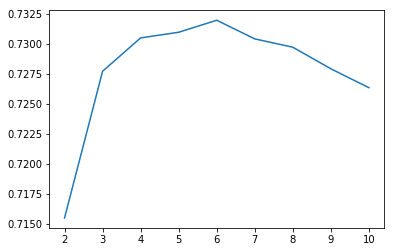

In [88]:
plt.plot(list(range(2,11)), tree_grid.cv_results_['mean_test_score'])
tree_grid.cv_results_

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [71]:
print(tree_grid.best_params_,tree_grid.best_score_) 
print(accuracy_score(y_valid,tree_grid.best_estimator_.predict(X_valid)))

## нет, нет или да, нет

{'max_depth': 6} 0.731959183673
0.72580952381


**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева четкий пик, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке?**
- да, да
- да, нет
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках.

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [114]:
last_df = pd.DataFrame() 
age_bins = pd.cut(df_new['age_years'], [45, 50, 55, 60, 65], right=False)
ap_hi_bins = pd.cut(df_new['ap_hi'], [120,140,160,180], right=False)
male_df = pd.DataFrame()
male_df['male'] = df_new['gender'].map(lambda gender: gender - 1)
last_df = last_df.append(pd.get_dummies(age_bins, prefix='age'))
last_df = pd.concat([last_df,pd.get_dummies(ap_hi_bins,prefix='ap_hi')],axis=1)
last_df = pd.concat([last_df, df_new[['cholesterol_1','cholesterol_2', 'cholesterol_3', 'smoke']], male_df],axis=1)
# print(last_df)
y = df_new['cardio']
# print(y)
tree_last = DecisionTreeClassifier(max_depth=3, random_state=17)
tree_last.fit(last_df, y)
export_graphviz(tree_last,out_file='../../img/hw3_tree_last.dot', feature_names=last_df.columns, filled=True)
!dot -Tpng '../../img/hw3_tree_last.dot' -o '../../img/hw3_tree_last.png'